In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage.morphology import binary_closing, binary_opening
from os.path import isfile

import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray
import cv2
import os

import cv2 as cv

from pathlib import Path
from scipy.ndimage.morphology import binary_closing, binary_opening
from os.path import isfile

In [3]:
# basic class for all objects
class Photo_object():
    # unique for each object parameters of contour extraction
    impath = None
    bc_kernel = None
    bo_kernel = None
    mask_bias = 0
    contour_idx = 0

    # function that extracts contour from the image and serializes it
    def read_contour(self, path_to_object, f_draw = False):
        img = cv.imread(path_to_object)
        imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        mask = imgray < np.mean(imgray) + self.mask_bias
        if self.bc_kernel:
            mask = binary_closing(mask, np.ones(self.bc_kernel))
        if self.bo_kernel:
            mask = binary_opening(mask, np.ones(self.bo_kernel))
        mask = 255 * np.asarray(mask, np.uint8)
        self.contour, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        self.contour = self.contour[self.contour_idx]
        np.save(f'{self.__class__.__name__}_contour', self.contour)
        if f_draw:
            _, ax = plt.subplots(1, 1)
            ax.imshow(mask, 'gray')
            cv.drawContours(img, self.contour, -1, (255, 0, 0), 2)
            _, ax = plt.subplots(1, 1)
            ax.imshow(img)
    
    # read contour or just load serialized one
    def __init__(self):
        if not isfile(f'{self.__class__.__name__}_contour.npy'):
            self.read_contour(self.impath, True)
        else:
            self.contour = np.load(f'{self.__class__.__name__}_contour.npy')

# classes for all objects

class button(Photo_object):
    impath = 'objects\\button.jpg'
    bc_kernel = (9,9)
    bo_kernel = (10, 10)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

class calculator(Photo_object):
    impath = 'objects\\calculator.jpg'
    bc_kernel = (7,7)
    bo_kernel = (10, 10)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

class circle(Photo_object):
    impath = 'objects\\circle.jpg'
    bc_kernel = (15,15)
    bo_kernel = (5,5)
    mask_bias = -10
    contour_idx = 0

    def __init__(self):
        super().__init__()

class clock(Photo_object):
    impath = 'objects\\clock.jpg'
    bc_kernel = (15, 15)
    bo_kernel = (5, 5)
    mask_bias = -40
    contour_idx = 2

    def __init__(self):
        super().__init__()

class coin(Photo_object):
    impath = 'objects\\coin.jpg'
    bc_kernel = (10, 10)
    bo_kernel = (6, 6)
    mask_bias = 0
    contour_idx = 2

    def __init__(self):
        super().__init__()


class controller(Photo_object):
    impath = 'objects\\controller.jpg'
    bc_kernel = (15, 15)
    bo_kernel = (5, 5)
    mask_bias = 5
    contour_idx = 1

    def __init__(self):
        super().__init__()

class king(Photo_object):
    impath = 'objects\\king.jpg'
    bc_kernel = (10, 10)
    bo_kernel = (6, 6)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

class mouse(Photo_object):
    impath = 'objects\\mouse.jpg'
    bc_kernel = (5, 5)
    bo_kernel = (8, 8)
    mask_bias = -20
    contour_idx = 1

    def __init__(self):
        super().__init__()

class pencil(Photo_object):
    impath = 'objects\\pencil.jpg'
    bc_kernel = (15, 15)
    bo_kernel = (6, 6)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

class scissors(Photo_object):
    impath = 'objects\\scissors.jpg'
    bc_kernel = (35, 35)
    bo_kernel = (3, 3)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

# array of all objects
OBJECTS = [button(), calculator(), circle(), clock(), coin(), controller(), king(), mouse(), pencil(), scissors()]

In [4]:
# function for extracting polygon contour out of image
def find_poly(img):
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # polygon must be drawn using black marker
    black_regions = cv.inRange(imhsv, (0, 0, 0), (360, 255, 140))
    contours, hierarchy = cv.findContours(black_regions, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    # polygon must be big enough
    min_area = img.shape[0] * img.shape[1] * 0.005
    polygons = []
    for i, c in enumerate(contours):
        if hierarchy[0, i, 3] != -1: # only holes (nested contours)
            _, _, w, h = cv.boundingRect(c)
            if w * h > min_area: # polygon must be bigger than possible noise
                # getting the inside of the possible polygon
                mask = np.zeros(imhsv.shape, dtype=np.uint8)
                cv.drawContours(mask,contours,i,(1, 1, 1),-1)

                M = cv.moments(c)
                cx = M["m10"] / M["m00"]
                cy = M["m01"] / M["m00"]
                # polygon must be above the middle
                if cy < img.shape[0]/2: 
                    polygons.append(c)
    if len(polygons) != 1:
        for polyg in polygons:
            cv.drawContours(img,[polyg],-1,(255, 0, 0),3)
        fig, ax = plt.subplots(1,1,dpi=150)
        ax.imshow(img)
        plt.show()
        raise Exception(f'ERROR: {len(polygons)} polygons where found')
    # making found curve look like a polygon decreasing number of vertices
    curve = polygons[0]    
    epsilon = 0.01 * cv.arcLength(curve, True)
    curve = cv.approxPolyDP(curve, epsilon, True)
    return curve

# helper function for contour scaling
def scale_contour(cnt, center, scale):
    cnt_norm = cnt - center
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + center
    return cnt_scaled

# function that approximates the polygon with the rectangle
# basic idea - iterative narrowing of the minimal area bounding rectangle until it fits the polygon
# after it fits - trying to enlarge it as much as possible
def find_internal_estimate(poly):
    # narrowing factor
    scale_factor = 0.9
    rect = cv.minAreaRect(poly)
    external_estim = cv.boxPoints(rect)
    center = np.asarray((rect[0][0], rect[0][1]))
    internal_estim = np.copy(external_estim)
    # narrow until the rectangle fits
    condition = [cv.pointPolygonTest(poly, pt, False) < 0 for pt in internal_estim]
    while any(condition):
        internal_estim = scale_contour(internal_estim, center, scale_factor)
        condition = [cv.pointPolygonTest(poly, pt, False) < 0 for pt in internal_estim]
    # find the furthest from the polygon edge rectangle vertex
    distance = np.asarray([cv.pointPolygonTest(poly, pt, True) for pt in internal_estim])
    idx_for_enlarge = np.argmax(distance)
    # function for internal estimate enlarging
    def enlarge_rect(sub_enl_ver_idx, dir_ver_idx):
        dir = internal_estim[idx_for_enlarge] - internal_estim[dir_ver_idx] 
        dir = dir / np.linalg.norm(dir) * (1 - scale_factor) * np.max(distance)
        condition = [cv.pointPolygonTest(poly, internal_estim[idx_for_enlarge], False) >= 0, cv.pointPolygonTest(poly, internal_estim[sub_enl_ver_idx], False) >= 0]
        while all(condition):
            new_points = [internal_estim[idx_for_enlarge] + dir, internal_estim[sub_enl_ver_idx] + dir]
            condition = [cv.pointPolygonTest(poly, new_points[0], False) >= 0, cv.pointPolygonTest(poly, new_points[1], False) >= 0]
            if all(condition):
                internal_estim[idx_for_enlarge] = new_points[0]
                internal_estim[sub_enl_ver_idx] = new_points[1]
    enlarge_rect((idx_for_enlarge + 1) % 4, idx_for_enlarge - 1)
    enlarge_rect(idx_for_enlarge - 1, (idx_for_enlarge + 1) % 4)
    return np.reshape(internal_estim, (4, 1, 2))

In [5]:
# function that originally must find and classify objects on the photo
# currently classification is working bad
def find_objects(img):
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # image binarization
    mask = cv.inRange(imhsv, (0, 0, 0), (360, 255, 140))
    M = cv.moments(mask)
    cxmask = M["m10"] / M["m00"]
    
    surimg = cv.cvtColor(cv.imread('objects\\surface.jpg'), cv.COLOR_BGR2RGB)
    circle_mask = cv.inRange(surimg, (0, 0, 0), (360, 255, 140))
    circle_mask = binary_closing(circle_mask, np.ones((5,5)))
    circle_mask = binary_opening(circle_mask, np.ones((5,5)))
    circle_mask = 255 * np.asarray(circle_mask, np.uint8)
    circle_mask = cv2.bitwise_not(circle_mask)
    if mask.shape[0] == 960:
        trans_img = cv2.transpose( circle_mask )
        circle_mask = cv2.flip(trans_img, 1)

    mask = mask & circle_mask
    mask = binary_closing(mask, np.ones((5,5)))
    mask = binary_opening(mask, np.ones((5,5)))
    mask = 255 * np.asarray(mask, np.uint8)
    # finding all external contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_area = img.shape[0] * img.shape[1]
    min_area = img_area * 0.0005
    max_area = img_area * 0.1
    detected = []
    metric = np.zeros(len(OBJECTS))
    global_mean = cv.mean(imhsv)
    # iterating over found contours
    for i in range(len(contours)):
        rect = cv.minAreaRect(contours[i])
        # objects are not too small and not too big
        if min_area <= rect[1][0] * rect[1][1]  <= max_area:
            mask = np.zeros(img.shape[:-1], np.uint8)
            cv.drawContours(mask, contours, i, 1, -1)
            mean = cv.mean(imhsv, mask=mask)
            # if the inside of the contour looks like white background, than it is part of it
            # these misleading contours are found because of sophisticated background
            if abs(mean[1] - global_mean[1]) < 15 and mean[2] > 120:
                continue
            # if this is an object, compare it with ideally scanned objects to classify it
            # compartion is made using Hu moments
            for j, o in enumerate(OBJECTS):
                metric[j] = cv.matchShapes(contours[i], o.contour, cv.CONTOURS_MATCH_I2, 0)
            # classification is made by the least metric value
            res = np.min(metric)
            name = OBJECTS[np.argmin(metric)].__class__.__name__
            detected.append((contours[i], res, name))
    return detected

In [6]:
# first necessary condition (polygon must be big enough)
def area_condition(objects, poly):
    objects_area = 0
    for o in objects:
        objects_area += cv.contourArea(o)
    return cv.contourArea(poly) > objects_area

# second necessary condition (each object must fit the polygon)
def lenght_condition(objects, poly):
    max_length = 0
    n = len(poly)
    # measuring all diagonales and sides of the polygon
    for i in range(n):
        for j in range(1, n - 1):
            max_length = max(max_length, np.linalg.norm(poly[i] - poly[(i + j) % n]))
    # if an object is too large to fit the polygon, than the condition is failed
    for o in objects:
        _, r = cv.minEnclosingCircle(o)
        if 2 * r > max_length:
            return False
    return True

# third necessary condition (width of the object must be less than width of external estimate)
def width_condition(objects, poly):
    ext_poly_est = cv.boxPoints(cv.minAreaRect(poly))
    estim_a = np.linalg.norm(ext_poly_est[0] - ext_poly_est[-1])
    estim_b = np.linalg.norm(ext_poly_est[0] - ext_poly_est[1])
    poly_width = min(estim_a, estim_b)
    obj_widths = np.empty((len(objects)))
    for i, o in enumerate(objects):
        coords = cv.boxPoints(cv.minAreaRect(o))
        a = np.linalg.norm(coords[0] - coords[-1])
        b = np.linalg.norm(coords[0] - coords[1])
        obj_widths[i] = min(a, b)
    return poly_width > np.max(obj_widths)

# sufficient condition, described in readme
def dummy_package(objects, internal_estimate):
    # measure length and width of the internal_estimate
    estim_a = np.linalg.norm(internal_estimate[0] - internal_estimate[-1])
    estim_b = np.linalg.norm(internal_estimate[0] - internal_estimate[1])
    estim_len = max(estim_a, estim_b)
    estim_wid = min(estim_a, estim_b)
    sizes = np.empty((len(objects), 2))
    # measure length and width of the external estimate for each object
    for i, o in enumerate(objects):
        coords = cv.boxPoints(cv.minAreaRect(o))
        a = np.linalg.norm(coords[0] - coords[-1])
        b = np.linalg.norm(coords[0] - coords[1])
        sizes[i] = np.asarray((max(a, b), min(a, b)))
    # trying to do dummy packing
    total_length = np.sum(sizes[:, 0])
    max_length = np.max(sizes[:, 0])
    total_width = np.sum(sizes[:, 1])
    max_width = np.max(sizes[:, 1])
    if total_length < estim_len and max_width < estim_wid:
        return True
    if total_width < estim_wid and max_length < estim_len:
        return True
    return False


10_yes.jpg


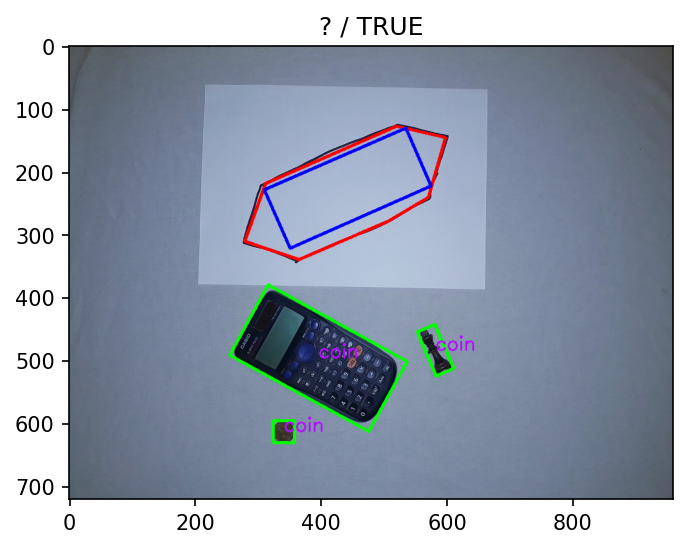

11_no.jpg


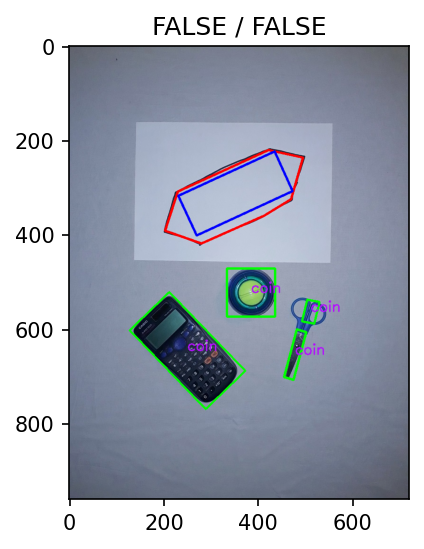

12_yes.jpg


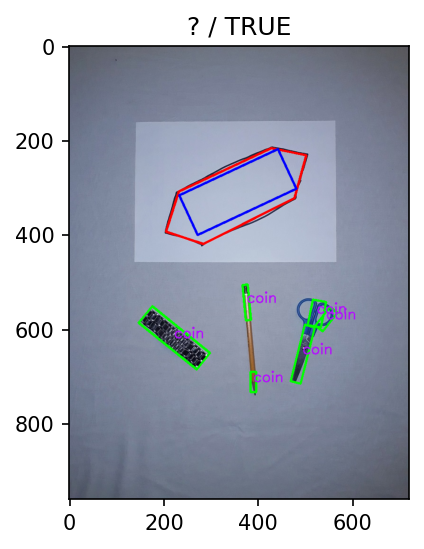

13_yes.jpg


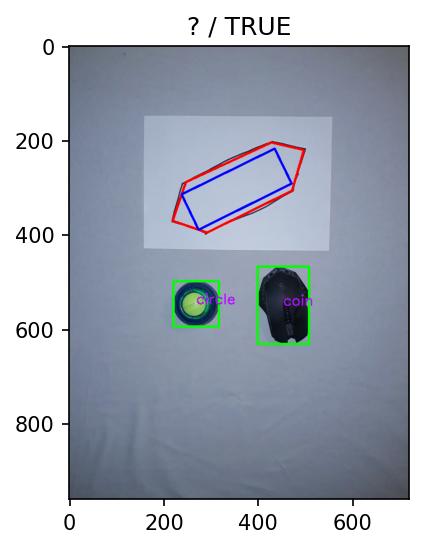

14_yes.jpg


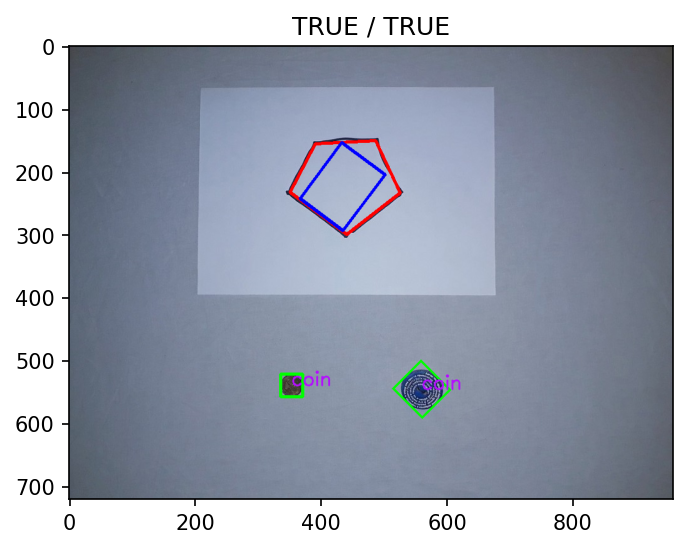

15_no.jpg


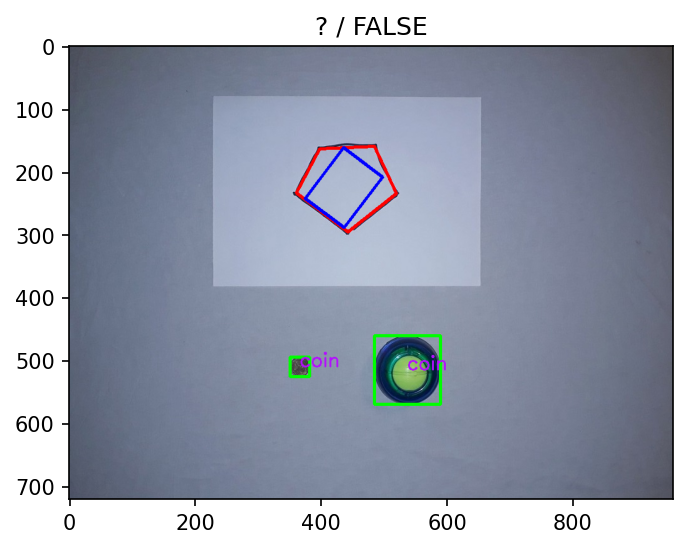

16_no.jpg


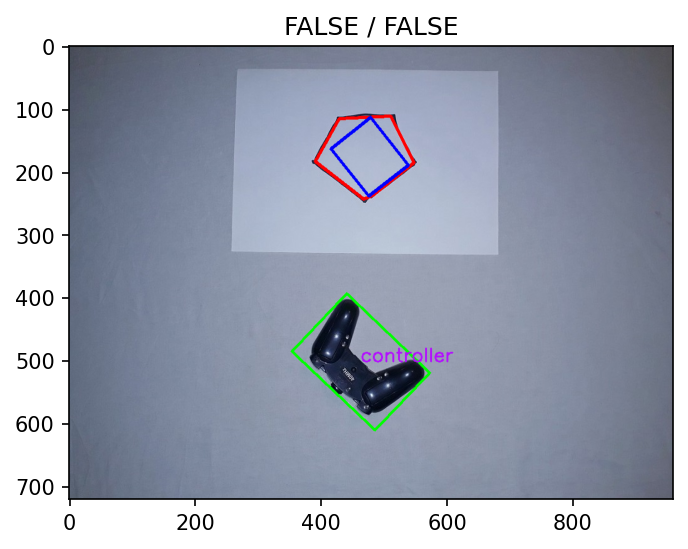

17_yes.jpg


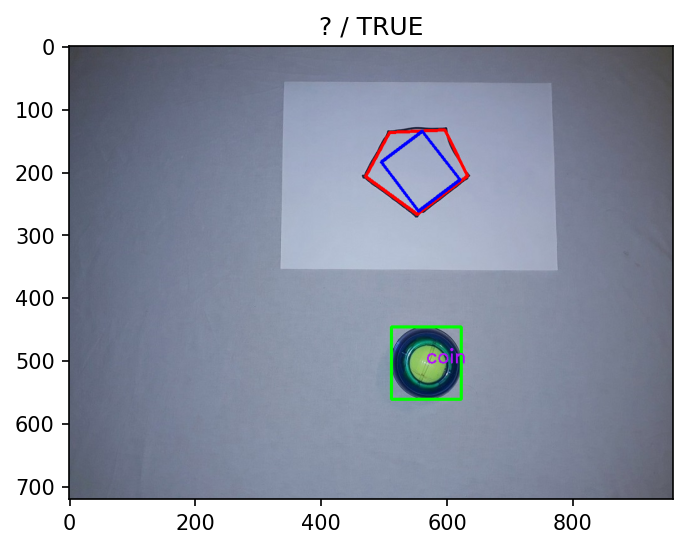

1_yes.jpg


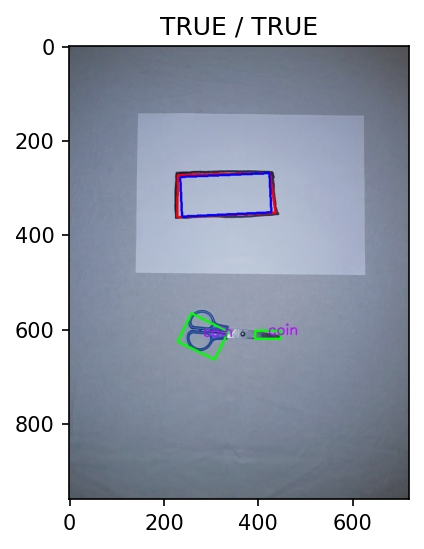

2_no.jpg


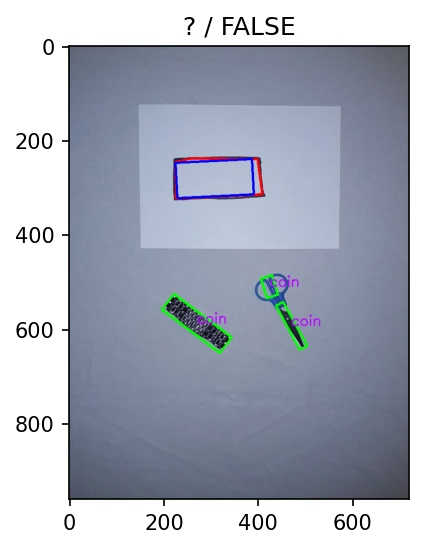

3_no.jpg


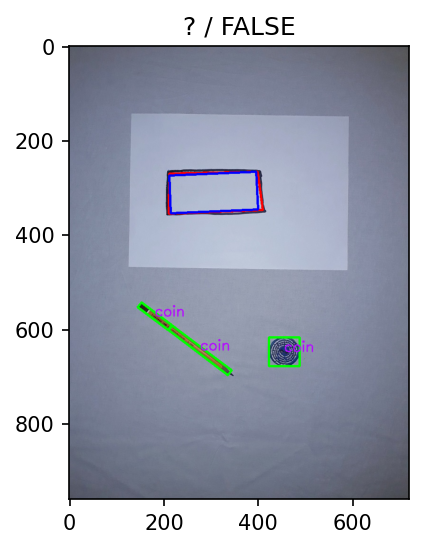

4_yes.jpg


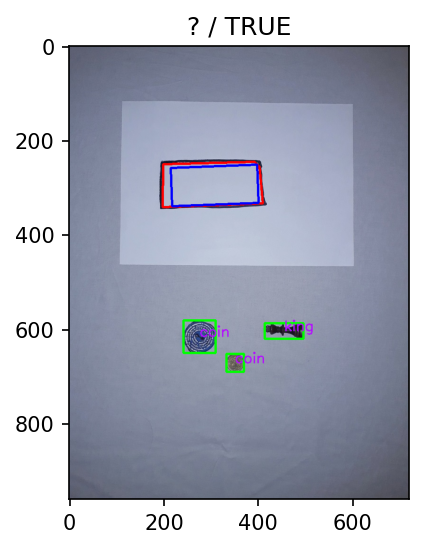

5_yes.jpg


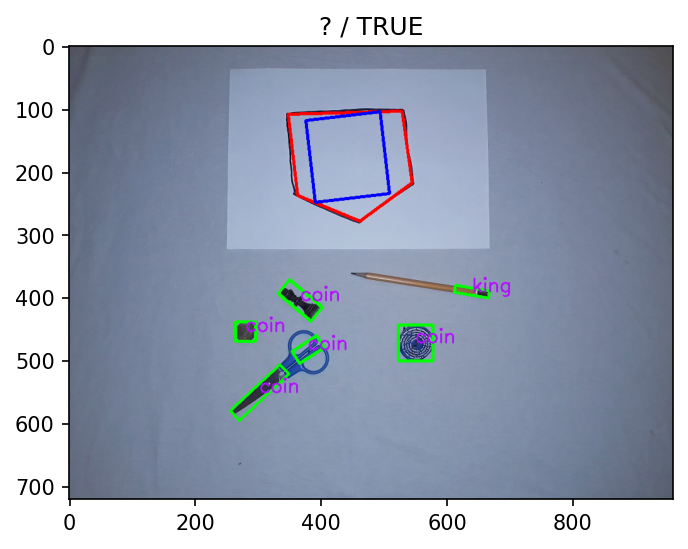

6_yes.jpg


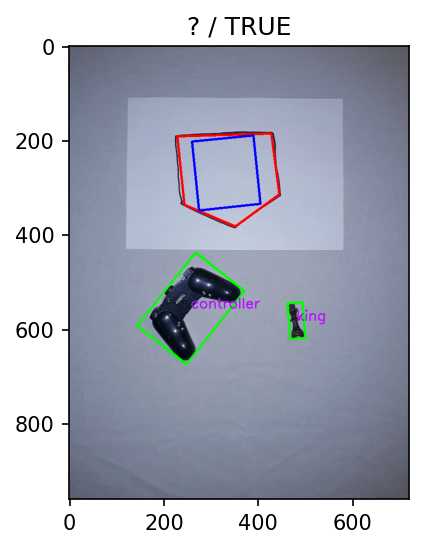

7_no.jpg


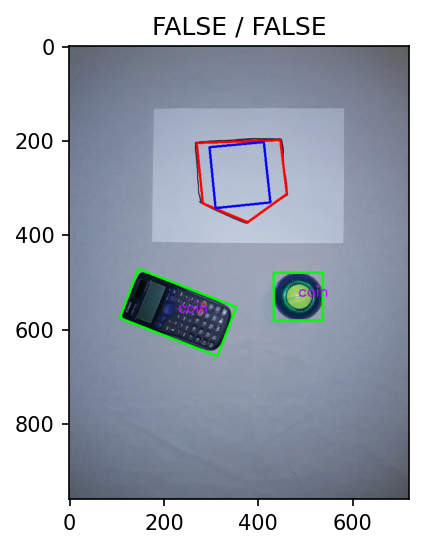

8_yes.jpg


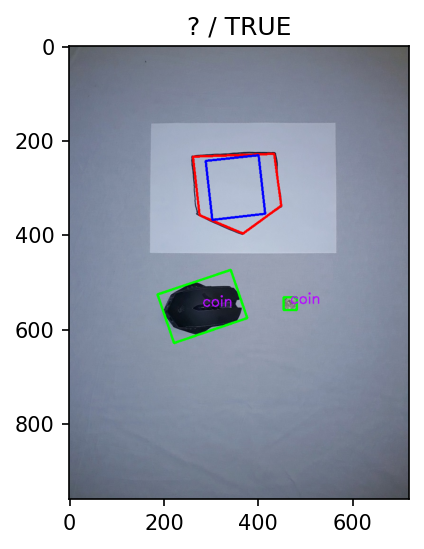

9_no.jpg


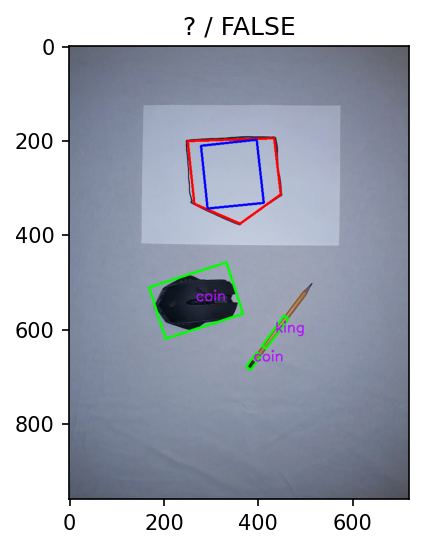

In [9]:
# function for demonstration 
def proceed_image(path):
    # determin the label for the task
    label = 'FALSE'
    if 'yes' in path:
        label = 'TRUE'
    img = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
    # find the polygon and cut it out of the image not to spoil objects detection stage
    poly = find_poly(img)
    scaled_poly = np.copy(poly)
    M = cv.moments(scaled_poly)
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    scaled_poly = scale_contour(scaled_poly, np.asarray((cx, cy)), 1.2)
    mask = np.zeros(img.shape[:-1], dtype=np.uint8)
    cv.drawContours(mask, [poly], -1, 1, -1)
    img_copy = np.copy(img)
    obj_info = find_objects(img_copy)
    mean_color = cv.mean(img, mask)
    cv.drawContours(img_copy, [np.int32(scaled_poly)], -1, mean_color, -1)
    # draw the found polygon
    obj_info = find_objects(img_copy)
    cv.polylines(img, [poly], True, (255, 0, 0), 3, cv.LINE_4)
    # draw the calculated internal estimate
    cv.polylines(img, [np.int32(find_internal_estimate(poly))], True, (0, 0, 255), 3, cv.LINE_4)
    contours = []
    fig, ax = plt.subplots(1, 1, dpi=150)
    # highlight found objects and print proposed classification with metric value
    for info in obj_info:
        rect = np.int0(cv.boxPoints(cv.minAreaRect(info[0])))
        cv.polylines(img,[rect],True,(0,255,0),3,cv.LINE_4)
        center = np.mean(rect,0)
        cv.putText(img, info[2], np.int0(center), cv.FONT_HERSHEY_SIMPLEX, 1, (180, 15, 255), 2, cv.LINE_4)
        contours.append(info[0])
    # check neccesary and sufficient conditions and print result
    if area_condition(contours, poly) and lenght_condition(contours, poly) and width_condition(contours, poly):
        if dummy_package(contours, find_internal_estimate(poly)):
            ax.set_title('TRUE / ' + label)
        else:
            ax.set_title('? / ' + label)
    else:
        ax.set_title('FALSE / ' + label)
    ax.imshow(img)

path = os.listdir('tests')
path.remove('Thumbs.db')
path
for file in path:
    print(str(file))
    proceed_image('tests\\' + str(file))
    plt.show()